In [1]:
import netCDF4
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import copy

In [2]:
def weighted_mse(y_true, y_pred):
    y_w = (y_true * 2000) + 1
    return T.mean(T.square((y_pred - y_true)*y_w), axis=-1)

In [3]:
data = netCDF4.Dataset('../Python/narrOps_200902.nc')

In [4]:
xBounds = [slice(30,240), slice(70, 300)]
yBounds = xBounds
shape = [210, 230]

In [5]:
var = ['air', 'shum', 'hgt', 'uwnd', 'vwnd']

In [6]:
x = np.ma.zeros((224,5,shape[0],shape[1]))

In [7]:
for i,v in enumerate(var):
    x[:,i] = data.variables[v][:,0,xBounds[0],xBounds[1]]

In [8]:
gt_data = netCDF4.Dataset('../Python/fuzzyCodsus_200902.nc')

In [9]:
y = gt_data.variables['front_images'][:,:,yBounds[0],yBounds[1]]

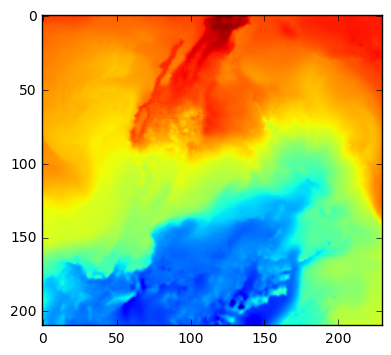

In [10]:
plt.imshow(x[0,0])

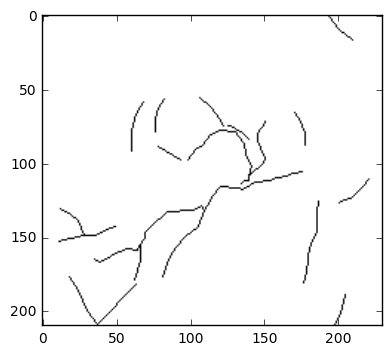

In [12]:
plt.imshow(y[0].max(0), cmap='gray')

In [10]:
mask = y.mask

In [11]:
y = np.asarray(y) / 255

In [12]:
#shuffle data
inds = np.arange(x.shape[0])

rng = np.random.RandomState(4)

rng.shuffle(inds)

x= x[inds]
y = y[inds]


In [13]:
# separate into train and val


trind = int(0.8*len(inds))

x_tr, y_tr = x[:trind].copy(), y[:trind].copy()
x_val, y_val = x[trind:].copy(),y[trind:].copy()

In [14]:
means = [x_tr[:,v].mean() for v in range(len(var))]

In [15]:
means

[masked_array(data = 276.149481732,
              mask = False,
        fill_value = 1e+20), masked_array(data = 0.00501986910291,
              mask = False,
        fill_value = 1e+20), masked_array(data = 138.747987092,
              mask = False,
        fill_value = 1e+20), masked_array(data = 0.644191528218,
              mask = False,
        fill_value = 1e+20), masked_array(data = -0.666525085207,
              mask = False,
        fill_value = 1e+20)]

In [16]:
for v in range(len(var)):
    x_tr[:,v] -= means[v]

In [17]:
stds = [x_tr[:,v].std() for v in range(len(var))]

In [18]:
for v in range(len(var)):
    x_tr[:,v] /= stds[v]

In [19]:
np.std(x_tr[:,1])

1.0000000000000002

In [20]:
x_mask = x_tr.mask

In [21]:
x_tr = np.asarray(x_tr)

In [22]:
if True == isinstance(x_mask, np.ndarray):
    x_tr[x_mask] = 0

In [23]:
x_tr.shape

(179, 5, 210, 230)

In [24]:
import keras

Using Theano backend.


In [25]:
from keras.models import Sequential

In [26]:
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

In [27]:
from keras.optimizers import SGD

In [28]:
from theano import tensor as T

In [29]:
base_filters = 10

In [30]:
model = Sequential()
input_kwargs = dict(input_shape=x_tr.shape[1:], padding=(2,2))
num_layers = 3
for i in range(num_layers):
    model.add(ZeroPadding2D(**input_kwargs))
    input_kwargs=dict(padding=(2,2))
    if i == num_layers - 1:
        model.add(Convolution2D(nb_filter=5, nb_col=5, nb_row=5,activation='sigmoid'))
    else:
        model.add(Convolution2D(nb_filter=10, nb_col=5, nb_row=5, activation='relu'))


In [31]:
model.compile(loss=weighted_mse, optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))

In [32]:
model.fit(x_tr, y_tr, nb_epoch=5, batch_size=32)

Epoch 1/5
179/179 [==============================] - 21s - loss: 651.4542    
Epoch 2/5
179/179 [==============================] - 21s - loss: 0.9968    
Epoch 3/5
179/179 [==============================] - 21s - loss: 0.9968    
Epoch 4/5
179/179 [==============================] - 21s - loss: 0.9968    
Epoch 5/5
179/179 [==============================] - 21s - loss: 0.9968    


In [179]:
preds = model.predict(x_tr[:5])

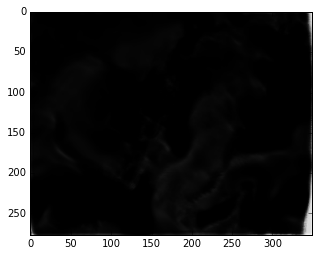

In [198]:
plt.imshow(preds[0,1], cmap='gray')

In [200]:
y_tr.sum() / np.product(y_tr.shape)

0.0016738452562566647